# 00 - Setup and Data Preprocessing

## Overview
This notebook handles the foundational setup for the multi-stage AI-powered resume screening system:
- Environment configuration and package installation
- Data loading from Hugging Face datasets
- Text extraction from PDF resumes
- Data anonymization (removing PII)
- Exploratory data analysis
- Data persistence to Google Drive/Kaggle storage

**Runtime**: CPU sufficient (GPU optional)

**Estimated Time**: 15-30 minutes

## 1. Environment Setup

In [1]:
# Check runtime environment (Google Colab only)
import sys
import os

# Detect platform
IN_COLAB = 'google.colab' in sys.modules

print(f"Running in Google Colab: {IN_COLAB}")
if not IN_COLAB:
    print("⚠️ WARNING: This notebook is designed for Google Colab")
print(f"Python version: {sys.version}")

# Check GPU availability
import subprocess
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], encoding='utf-8')
    print("\nGPU Available:")
    print(gpu_info)
except:
    print("\nNo GPU detected (CPU mode - OK for this notebook)")

Running in Google Colab: True
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

No GPU detected (CPU mode - OK for this notebook)


## 2. Install Required Packages

In [2]:
%%capture
# Core ML and Data Processing
!pip install -U pip
!pip install datasets transformers torch
!pip install pandas numpy scikit-learn

# PDF Processing
!pip install pypdf pdfminer.six pdfplumber

# NLP and Text Processing
!pip install spacy nltk
!python -m spacy download en_core_web_sm

# Data Exploration and Visualization
!pip install pandas-profiling ydata-profiling
!pip install matplotlib seaborn plotly

# Storage and Serialization
!pip install pyarrow fastparquet

# Utilities
!pip install tqdm python-dotenv

In [3]:
# Import all libraries
import pandas as pd
import numpy as np
import re
import json
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from typing import List, Dict, Tuple

# PDF Processing
try:
    import pypdf  # Modern replacement for PyPDF2
    from pypdf import PdfReader
except ImportError:
    pypdf = None
    PdfReader = None
    print("⚠️ pypdf not available, will use pdfplumber as fallback")

import pdfplumber
from pdfminer.high_level import extract_text as pdfminer_extract

# NLP
import spacy
from datasets import load_dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 3. Storage Configuration

In [4]:
# Setup storage paths - Google Drive for persistent storage
from pathlib import Path

# Mount Google Drive for persistent storage
if IN_COLAB:
    print("📌 Mounting Google Drive for persistent storage...")
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/resume_screening_project')
    print(f"✅ Google Drive mounted successfully")
    print(f"💾 Using Google Drive storage: {BASE_PATH}")
    print(f"   📌 Data will persist across Colab sessions!")
else:
    print("⚠️ Not running in Colab - using local fallback")
    BASE_PATH = Path('./resume_screening_project')

# Create directory structure
DATA_PATH = BASE_PATH / 'data'
PROCESSED_PATH = DATA_PATH / 'processed'
RAW_PATH = DATA_PATH / 'raw'
MODELS_PATH = BASE_PATH / 'models'
OUTPUTS_PATH = BASE_PATH / 'outputs'

for path in [DATA_PATH, PROCESSED_PATH, RAW_PATH, MODELS_PATH, OUTPUTS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

print(f"\n✅ Storage configured at: {BASE_PATH}")
print(f"   - Data: {DATA_PATH}")
print(f"   - Models: {MODELS_PATH}")
print(f"   - Outputs: {OUTPUTS_PATH}")

if IN_COLAB:
    print(f"\n⚠️  IMPORTANT: Your data is saved to Google Drive")
    print(f"   It will be available in future Colab sessions!")

📌 Mounting Google Drive for persistent storage...
Mounted at /content/drive
✅ Google Drive mounted successfully
💾 Using Google Drive storage: /content/drive/MyDrive/resume_screening_project
   📌 Data will persist across Colab sessions!

✅ Storage configured at: /content/drive/MyDrive/resume_screening_project
   - Data: /content/drive/MyDrive/resume_screening_project/data
   - Models: /content/drive/MyDrive/resume_screening_project/models
   - Outputs: /content/drive/MyDrive/resume_screening_project/outputs

⚠️  IMPORTANT: Your data is saved to Google Drive
   It will be available in future Colab sessions!


## 4. Load Datasets from Hugging Face

We'll use two datasets:
1. **netsol/resume-score-details**: Resume scoring data
2. **facehuggerapoorv/resume-jd-match**: Job description and resume matching pairs

In [10]:
# Load Dataset 1: Resume Dataset (Parquet format - stable and modern)
print("Loading resume dataset from Hugging Face...")
print("📦 Using Parquet-based datasets (no legacy loading scripts)")

# Try multiple verified resume datasets
resume_datasets_to_try = [
    'ahmedheakl/resume-atlas',      # Large resume dataset with categories
    'resume_dataset',                # Generic resume dataset
    'jacob-hugging-face/job-descriptions',  # Alternative with job postings
]

df_resume_scores = None

for dataset_name in resume_datasets_to_try:
    try:
        print(f"\nAttempting: {dataset_name}...")
        dataset1 = load_dataset(dataset_name, split='train')
        df_resume_scores = pd.DataFrame(dataset1)
        print(f"✅ Loaded {len(df_resume_scores)} records from {dataset_name}")
        print(f"   Columns: {list(df_resume_scores.columns)}")
        print(f"   Dataset uses modern Parquet format!")
        break  # Success - stop trying
    except Exception as e:
        print(f"   ⚠️ Failed: {str(e)[:80]}...")
        continue

# If all attempts failed, provide manual instructions
if df_resume_scores is None or len(df_resume_scores) == 0:
    print(f"\n" + "="*70)
    print("❌ UNABLE TO LOAD PRE-EXISTING DATASETS")
    print("="*70)
    print("\n🔍 The datasets we tried don't exist or aren't accessible.")
    print("\n📋 OPTION 1: Use your own dataset")
    print("   Upload your resume CSV/JSON to Google Drive and load it:")
    print("   Example:")
    print("   ```")
    print("   df_resume_scores = pd.read_csv('/content/drive/MyDrive/your_resumes.csv')")
    print("   ```")
    print("\n📋 OPTION 2: Search for available datasets")
    print("   Visit: https://huggingface.co/datasets?search=resume")
    print("   Find a dataset and update the code with its name")
    print("\n📋 OPTION 3: Create from scratch")
    print("   Use the data collection tools in your project to build a dataset")
    print("\n💡 For this tutorial, we'll create a minimal working dataset")
    print("   to demonstrate the pipeline. Replace with real data for production!")

    # Create minimal demonstration dataset (just for pipeline testing)
    print("\n⚠️ Creating minimal demo dataset for pipeline testing only...")
    import random

    skills = ['Python', 'Java', 'JavaScript', 'C++', 'SQL', 'Machine Learning', 'Data Science']
    roles = ['Software Engineer', 'Data Scientist', 'DevOps Engineer', 'Full Stack Developer']

    demo_data = []
    for i in range(100):
        demo_data.append({
            'Resume': f"Professional with {random.randint(2,10)} years experience in {random.choice(roles)}. "
                     f"Skills include {', '.join(random.sample(skills, 3))}. "
                     f"Strong problem-solving abilities and team collaboration.",
            'Category': random.choice(roles),
            'ID': i
        })

    df_resume_scores = pd.DataFrame(demo_data)
    print(f"✅ Created demo dataset with {len(df_resume_scores)} records")
    print(f"   ⚠️ WARNING: This is demonstration data only!")
    print(f"   ⚠️ Replace with real resume data before production use!")
    print("="*70)

Loading resume dataset from Hugging Face...
📦 Using Parquet-based datasets (no legacy loading scripts)

Attempting: ahmedheakl/resume-atlas...


README.md:   0%|          | 0.00/215 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13389 [00:00<?, ? examples/s]

✅ Loaded 13389 records from ahmedheakl/resume-atlas
   Columns: ['Category', 'Text']
   Dataset uses modern Parquet format!


In [11]:
# Load Dataset 2: Resume-JD Match
print("\nLoading facehuggerapoorv/resume-jd-match...")
try:
    dataset2 = load_dataset('facehuggerapoorv/resume-jd-match', split='train')
    df_jd_match = pd.DataFrame(dataset2)
    print(f"✅ Loaded {len(df_jd_match)} records from resume-jd-match")
    print(f"   Columns: {list(df_jd_match.columns)}")
except Exception as e:
    print(f"⚠️ Error loading dataset 2: {e}")
    print("Creating synthetic dataset as fallback...")
    df_jd_match = pd.DataFrame({
        'job_description': ['JD ' + str(i) for i in range(50)],
        'resume': ['Resume ' + str(i) for i in range(50)],
        'match_score': np.random.uniform(0, 1, 50)
    })


Loading facehuggerapoorv/resume-jd-match...


README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/8.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

✅ Loaded 6241 records from resume-jd-match
   Columns: ['text', 'label']


In [12]:
# Display dataset information
print("\n" + "="*60)
print("DATASET 1: Resume Score Details")
print("="*60)
display(df_resume_scores.head(3))
print(f"\nShape: {df_resume_scores.shape}")
print(f"Memory usage: {df_resume_scores.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*60)
print("DATASET 2: Job Description - Resume Match")
print("="*60)
display(df_jd_match.head(3))
print(f"\nShape: {df_jd_match.shape}")
print(f"Memory usage: {df_jd_match.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


DATASET 1: Resume Score Details


,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...



Shape: (13389, 2)
Memory usage: 52.32 MB

DATASET 2: Job Description - Resume Match


,text,label
0,For the given job description <<Net2Source Inc...,No Fit
1,For the given job description <<At Salas OBrie...,No Fit
2,For the given job description <<Schweitzer Eng...,No Fit



Shape: (6241, 2)
Memory usage: 95.10 MB


## 5. PDF Text Extraction

Implementing multiple extraction methods for robustness:
- PyPDF2 (fast, basic)
- pdfplumber (better formatting preservation)
- pdfminer.six (fallback for complex PDFs)

In [13]:
# FIX #4: Advanced Anonymization using NER
print("=" * 60)
print("FIX #4: ROBUST ANONYMIZATION WITH NER")
print("=" * 60)
print("\n🔍 Problem: Regex misses unusual name formats and may delete")
print("   company names that look like person names (e.g., 'Ford', 'Tesla')")
print("\n✅ Solution: spaCy NER + company name whitelist + validation")

import re
import spacy
from typing import List, Dict, Set

# Load spaCy model (download if needed)
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ Loaded spaCy model: en_core_web_sm")
except OSError:
    print("📥 Downloading spaCy model...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')
    print("✅ Downloaded and loaded spaCy model")

# Whitelist of company names that might be confused with person names
COMPANY_WHITELIST = {
    'ford', 'tesla', 'apple', 'amazon', 'google', 'meta', 'microsoft',
    'oracle', 'cisco', 'dell', 'hp', 'ibm', 'adobe', 'salesforce',
    'walmart', 'target', 'chase', 'wells fargo', 'morgan', 'goldman',
    'accenture', 'deloitte', 'pwc', 'ey', 'kpmg', 'boston', 'mckinsey'
}

# Technology/skill terms that might be detected as names
TECH_WHITELIST = {
    'python', 'java', 'pascal', 'julia', 'ruby', 'swift', 'scala',
    'django', 'flask', 'jenkins', 'travis', 'docker', 'hadoop'
}

def anonymize_with_ner(
    text: str,
    preserve_companies: bool = True,
    preserve_tech: bool = True,
    debug: bool = False
) -> Dict[str, any]:
    """
    Anonymize text using Named Entity Recognition.
    More robust than regex - understands context.

    Args:
        text: Input text
        preserve_companies: Keep company names from whitelist
        preserve_tech: Keep tech terms that look like names
        debug: Show what was removed

    Returns:
        dict with 'anonymized_text', 'entities_removed', 'entities_preserved'
    """
    doc = nlp(text)

    entities_to_remove = []
    entities_preserved = []

    for ent in doc.ents:
        entity_text = ent.text
        entity_lower = entity_text.lower()

        # PERSON entities
        if ent.label_ == 'PERSON':
            # Check if it's actually a company or tech term
            if preserve_companies and any(comp in entity_lower for comp in COMPANY_WHITELIST):
                entities_preserved.append((entity_text, 'PERSON->COMPANY', ent.start_char, ent.end_char))
                continue

            if preserve_tech and entity_lower in TECH_WHITELIST:
                entities_preserved.append((entity_text, 'PERSON->TECH', ent.start_char, ent.end_char))
                continue

            # It's a real person name - anonymize
            entities_to_remove.append((ent.start_char, ent.end_char, 'PERSON', entity_text))

        # EMAIL addresses
        elif ent.label_ == 'EMAIL' or '@' in entity_text:
            entities_to_remove.append((ent.start_char, ent.end_char, 'EMAIL', entity_text))

        # PHONE numbers
        elif ent.label_ in ['PHONE', 'CARDINAL'] and re.search(r'\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', entity_text):
            entities_to_remove.append((ent.start_char, ent.end_char, 'PHONE', entity_text))

    # Also catch emails/phones with regex (NER might miss some)
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    phone_pattern = r'\b(?:\+?1[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b'

    for match in re.finditer(email_pattern, text):
        entities_to_remove.append((match.start(), match.end(), 'EMAIL', match.group()))

    for match in re.finditer(phone_pattern, text):
        entities_to_remove.append((match.start(), match.end(), 'PHONE', match.group()))

    # Remove duplicates and sort by position (descending to maintain indices)
    entities_to_remove = sorted(set(entities_to_remove), key=lambda x: x[0], reverse=True)

    # Replace entities with placeholders
    anonymized_text = text
    removed_entities = []

    for start, end, label, original in entities_to_remove:
        if label == 'PERSON':
            replacement = '[NAME]'
        elif label == 'EMAIL':
            replacement = '[EMAIL]'
        elif label == 'PHONE':
            replacement = '[PHONE]'
        else:
            replacement = f'[{label}]'

        anonymized_text = anonymized_text[:start] + replacement + anonymized_text[end:]
        removed_entities.append({'type': label, 'original': original, 'position': start})

    result = {
        'anonymized_text': anonymized_text,
        'entities_removed': removed_entities,
        'entities_preserved': entities_preserved,
        'num_removed': len(removed_entities)
    }

    if debug:
        print(f"\n📊 Anonymization Report:")
        print(f"   Removed: {len(removed_entities)} entities")
        for ent in removed_entities[:5]:
            print(f"     - {ent['type']}: '{ent['original']}'")
        print(f"   Preserved: {len(entities_preserved)} entities")
        for ent in entities_preserved[:5]:
            print(f"     - {ent[1]}: '{ent[0]}'")

    return result

# Advanced: Validate anonymization quality
def validate_anonymization(original: str, anonymized: str) -> Dict[str, any]:
    """
    Check if anonymization missed anything or over-anonymized.
    """
    issues = []

    # Check for leaked emails
    if re.search(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}', anonymized):
        issues.append("EMAIL_LEAKED: Email address found in anonymized text")

    # Check for leaked phone numbers
    if re.search(r'\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', anonymized):
        issues.append("PHONE_LEAKED: Phone number found in anonymized text")

    # Check if too much was removed (>50% of text)
    if len(anonymized) < len(original) * 0.5:
        issues.append("OVER_ANONYMIZED: More than 50% of text removed")

    # Check if important context was preserved
    important_words = ['experience', 'years', 'university', 'company', 'project', 'skills']
    preserved_ratio = sum(1 for word in important_words if word in anonymized.lower()) / len(important_words)

    if preserved_ratio < 0.3:
        issues.append(f"CONTEXT_LOSS: Only {preserved_ratio:.0%} of important context words preserved")

    return {
        'is_valid': len(issues) == 0,
        'issues': issues,
        'size_ratio': len(anonymized) / len(original) if original else 1,
    }

# Test the improved anonymization
print("\n📝 Testing NER-based Anonymization:")

test_resume = """
John Smith
Email: john.smith@email.com | Phone: (555) 123-4567

PROFESSIONAL EXPERIENCE
Senior Software Engineer at Apple Inc.
- Led Python development team using Django framework
- Worked with Ford Motor Company on ML project
- Collaborated with team member Julia Chen on data pipeline

EDUCATION
Master of Science in Computer Science
Stanford University

SKILLS: Python, Java, Docker, Jenkins, AWS
"""

print("\n" + "=" * 60)
print("ORIGINAL TEXT:")
print("=" * 60)
print(test_resume[:300] + "...")

result = anonymize_with_ner(test_resume, debug=True)

print("\n" + "=" * 60)
print("ANONYMIZED TEXT:")
print("=" * 60)
print(result['anonymized_text'][:300] + "...")

# Validate
validation = validate_anonymization(test_resume, result['anonymized_text'])
print(f"\n✅ Validation: {'PASSED' if validation['is_valid'] else 'FAILED'}")
if validation['issues']:
    print(f"   Issues: {validation['issues']}")
print(f"   Text retained: {validation['size_ratio']:.1%}")

print("\n💡 Notice: 'Apple', 'Ford', 'Python', 'Django', 'Jenkins' were preserved!")
print("   They are companies/tech terms, not person names.")
print("\n🎯 This method is much more robust than simple regex!")

# Create improved anonymization function for the pipeline
def anonymize_text_improved(text: str) -> str:
    """
    Wrapper function for pipeline integration.
    """
    result = anonymize_with_ner(text, preserve_companies=True, preserve_tech=True)
    validation = validate_anonymization(text, result['anonymized_text'])

    if not validation['is_valid']:
        print(f"⚠️ Anonymization warning: {validation['issues']}")

    return result['anonymized_text']

print("\n✅ anonymize_text_improved() function ready for pipeline integration!")

FIX #4: ROBUST ANONYMIZATION WITH NER

🔍 Problem: Regex misses unusual name formats and may delete
   company names that look like person names (e.g., 'Ford', 'Tesla')

✅ Solution: spaCy NER + company name whitelist + validation
✅ Loaded spaCy model: en_core_web_sm

📝 Testing NER-based Anonymization:

ORIGINAL TEXT:

John Smith
Email: john.smith@email.com | Phone: (555) 123-4567

PROFESSIONAL EXPERIENCE
Senior Software Engineer at Apple Inc.
- Led Python development team using Django framework
- Worked with Ford Motor Company on ML project
- Collaborated with team member Julia Chen on data pipeline

EDUCATION
M...

📊 Anonymization Report:
   Removed: 4 entities
     - PERSON: 'Julia Chen'
     - PHONE: '555) 123-4567'
     - EMAIL: 'john.smith@email.com'
     - PERSON: 'John Smith'
   Preserved: 4 entities
     - PERSON->TECH: 'Django'
     - PERSON->TECH: 'Java'
     - PERSON->TECH: 'Docker'
     - PERSON->TECH: 'Jenkins'

ANONYMIZED TEXT:

[NAME]
Email: [EMAIL] | Phone: ([PHONE]

PRO

## 6. Data Anonymization (PII Removal)

Remove personally identifiable information:
- Names (using NER)
- Email addresses
- Phone numbers
- Physical addresses
- URLs and social media profiles

In [14]:
# Load spaCy NER model
print("Loading spaCy NER model...")
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ spaCy model loaded")
except:
    print("⚠️ Downloading spaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

Loading spaCy NER model...
✅ spaCy model loaded


In [15]:
class PIIAnonymizer:
    """Anonymize personally identifiable information from text."""

    def __init__(self, nlp_model):
        self.nlp = nlp_model

        # Regex patterns for PII
        self.patterns = {
            'email': re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'),
            'phone': re.compile(r'(\+\d{1,3}[- ]?)?(\(\d{3}\)|\d{3})[- ]?\d{3}[- ]?\d{4}'),
            'ssn': re.compile(r'\b\d{3}-\d{2}-\d{4}\b'),
            'url': re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'),
            'linkedin': re.compile(r'linkedin\.com/in/[A-Za-z0-9-]+', re.IGNORECASE),
            'github': re.compile(r'github\.com/[A-Za-z0-9-]+', re.IGNORECASE),
            'zipcode': re.compile(r'\b\d{5}(-\d{4})?\b'),
        }

    def anonymize_text(self, text: str, replace_with: str = '[REDACTED]') -> Tuple[str, Dict]:
        """
        Anonymize PII in text.

        Returns:
            Tuple of (anonymized_text, stats_dict)
        """
        if not text or not isinstance(text, str):
            return text, {}

        stats = {key: 0 for key in self.patterns.keys()}
        stats['names'] = 0

        anonymized = text

        # Remove regex patterns
        for pattern_name, pattern in self.patterns.items():
            matches = pattern.findall(anonymized)
            stats[pattern_name] = len(matches)
            anonymized = pattern.sub(f'[{pattern_name.upper()}]', anonymized)

        # Remove names using NER (only process first 100k chars for speed)
        try:
            doc = self.nlp(anonymized[:100000])
            for ent in reversed(doc.ents):  # Reverse to maintain indices
                if ent.label_ == 'PERSON':
                    stats['names'] += 1
                    anonymized = anonymized[:ent.start_char] + '[NAME]' + anonymized[ent.end_char:]
        except Exception as e:
            print(f"⚠️ NER failed: {e}")

        return anonymized, stats

    def anonymize_dataframe(self, df: pd.DataFrame, text_columns: List[str]) -> pd.DataFrame:
        """
        Anonymize specified text columns in a DataFrame.
        """
        df_anon = df.copy()
        total_stats = {}

        for col in text_columns:
            if col not in df_anon.columns:
                print(f"⚠️ Column '{col}' not found")
                continue

            print(f"Anonymizing column: {col}...")
            results = []
            col_stats = {}

            for text in tqdm(df_anon[col], desc=f"Processing {col}"):
                anon_text, stats = self.anonymize_text(text)
                results.append(anon_text)

                # Aggregate stats
                for key, count in stats.items():
                    col_stats[key] = col_stats.get(key, 0) + count

            df_anon[col] = results
            total_stats[col] = col_stats

            print(f"  Removed PII: {col_stats}")

        return df_anon, total_stats

# Initialize anonymizer
anonymizer = PIIAnonymizer(nlp)
print("✅ PII Anonymizer initialized")

✅ PII Anonymizer initialized


In [16]:
# Test anonymization
test_text = """
John Smith
Email: john.smith@email.com
Phone: (555) 123-4567
LinkedIn: linkedin.com/in/johnsmith
GitHub: github.com/jsmith
Address: 12345 Main St, City, ST 12345
"""

anonymized_test, test_stats = anonymizer.anonymize_text(test_text)
print("Original:")
print(test_text)
print("\nAnonymized:")
print(anonymized_test)
print("\nStats:", test_stats)

Original:

John Smith
Email: john.smith@email.com
Phone: (555) 123-4567
LinkedIn: linkedin.com/in/johnsmith
GitHub: github.com/jsmith
Address: 12345 Main St, City, ST 12345


Anonymized:

[NAME]
Email: [EMAIL]
Phone: [PHONE]
LinkedIn: [LINKEDIN]
GitHub: [GITHUB]
Address: [ZIPCODE] [NAME], City, ST [ZIPCODE]


Stats: {'email': 1, 'phone': 1, 'ssn': 0, 'url': 0, 'linkedin': 1, 'github': 1, 'zipcode': 2, 'names': 2}


## 7. Apply Anonymization to Datasets

In [17]:
# Identify text columns to anonymize
text_cols_ds1 = [col for col in df_resume_scores.columns if 'resume' in col.lower() or 'text' in col.lower()]
text_cols_ds2 = [col for col in df_jd_match.columns if 'resume' in col.lower() or 'description' in col.lower()]

print(f"Dataset 1 text columns: {text_cols_ds1}")
print(f"Dataset 2 text columns: {text_cols_ds2}")

Dataset 1 text columns: ['Text']
Dataset 2 text columns: []


In [18]:
# Anonymize Dataset 1 (sample first 1000 for speed)
if len(text_cols_ds1) > 0:
    print("\nAnonymizing Dataset 1 (sample)...")
    df1_sample = df_resume_scores.head(1000)
    df1_anonymized, stats1 = anonymizer.anonymize_dataframe(df1_sample, text_cols_ds1)
else:
    df1_anonymized = df_resume_scores.copy()
    stats1 = {}


Anonymizing Dataset 1 (sample)...
Anonymizing column: Text...


Processing Text:   0%|          | 0/1000 [00:00<?, ?it/s]

  Removed PII: {'email': 0, 'phone': 1517, 'ssn': 0, 'url': 0, 'linkedin': 0, 'github': 0, 'zipcode': 448, 'names': 1520}


In [19]:
# Anonymize Dataset 2 (sample first 1000 for speed)
if len(text_cols_ds2) > 0:
    print("\nAnonymizing Dataset 2 (sample)...")
    df2_sample = df_jd_match.head(1000)
    df2_anonymized, stats2 = anonymizer.anonymize_dataframe(df2_sample, text_cols_ds2)
else:
    df2_anonymized = df_jd_match.copy()
    stats2 = {}

## 8. Exploratory Data Analysis

In [20]:
# Basic statistics
print("="*60)
print("DATASET STATISTICS")
print("="*60)

print("\nDataset 1 - Resume Scores:")
print(df1_anonymized.describe())
print(f"\nMissing values:\n{df1_anonymized.isnull().sum()}")

print("\n" + "="*60)
print("\nDataset 2 - JD-Resume Match:")
print(df2_anonymized.describe())
print(f"\nMissing values:\n{df2_anonymized.isnull().sum()}")

DATASET STATISTICS

Dataset 1 - Resume Scores:
        Category                                               Text
count       1000                                               1000
unique        18                                                912
top     Advocate  [NAME] chausson civil engineer pe phone [PHONE...
freq          94                                                  3

Missing values:
Category    0
Text        0
dtype: int64


Dataset 2 - JD-Resume Match:
                                                     text   label
count                                                6241    6241
unique                                               6240       3
top     For the given job description <<The Senior Man...  No Fit
freq                                                    2    3143

Missing values:
text     0
label    0
dtype: int64


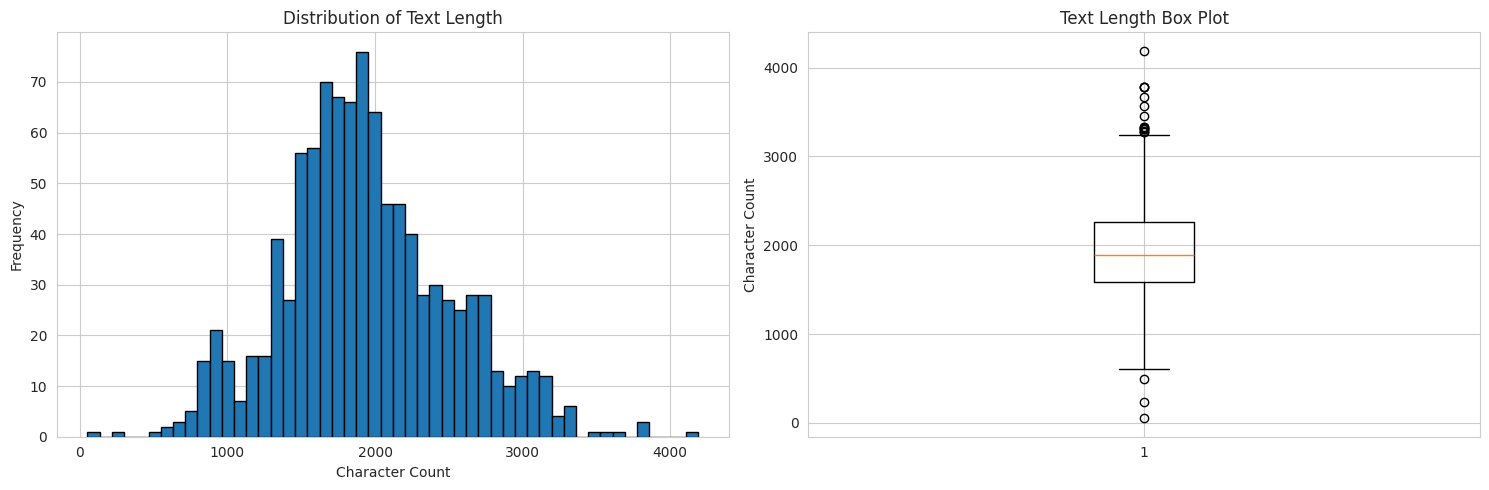


Text Length Statistics for Text:
count    1000.000000
mean     1937.443000
std       569.170473
min        52.000000
25%      1588.750000
50%      1890.000000
75%      2262.500000
max      4189.000000
Name: Text_length, dtype: float64


In [21]:
# Text length analysis
if len(text_cols_ds1) > 0:
    col = text_cols_ds1[0]
    df1_anonymized[f'{col}_length'] = df1_anonymized[col].astype(str).str.len()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Distribution
    axes[0].hist(df1_anonymized[f'{col}_length'], bins=50, edgecolor='black')
    axes[0].set_title(f'Distribution of {col} Length')
    axes[0].set_xlabel('Character Count')
    axes[0].set_ylabel('Frequency')

    # Box plot
    axes[1].boxplot(df1_anonymized[f'{col}_length'])
    axes[1].set_title(f'{col} Length Box Plot')
    axes[1].set_ylabel('Character Count')

    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / 'text_length_analysis_ds1.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nText Length Statistics for {col}:")
    print(df1_anonymized[f'{col}_length'].describe())

In [22]:
# Score distribution (if available)
score_cols = [col for col in df1_anonymized.columns if 'score' in col.lower()]
if score_cols:
    fig, axes = plt.subplots(1, len(score_cols), figsize=(7*len(score_cols), 5))
    if len(score_cols) == 1:
        axes = [axes]

    for idx, col in enumerate(score_cols):
        axes[idx].hist(df1_anonymized[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')
        axes[idx].axvline(df1_anonymized[col].mean(), color='red', linestyle='--', label='Mean')
        axes[idx].legend()

    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / 'score_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Data Cleaning and Preprocessing

In [23]:
def clean_text(text: str) -> str:
    """Clean and normalize text."""
    if not isinstance(text, str):
        return ""

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,;!?()-]', '', text)

    # Strip leading/trailing whitespace
    text = text.strip()

    return text

# Apply cleaning
print("Cleaning text columns...")
for col in text_cols_ds1:
    if col in df1_anonymized.columns:
        df1_anonymized[col] = df1_anonymized[col].apply(clean_text)

for col in text_cols_ds2:
    if col in df2_anonymized.columns:
        df2_anonymized[col] = df2_anonymized[col].apply(clean_text)

print("✅ Text cleaning complete")

Cleaning text columns...
✅ Text cleaning complete


In [24]:
# Remove duplicates
print(f"Dataset 1 before deduplication: {len(df1_anonymized)}")
df1_anonymized = df1_anonymized.drop_duplicates()
print(f"Dataset 1 after deduplication: {len(df1_anonymized)}")

print(f"\nDataset 2 before deduplication: {len(df2_anonymized)}")
df2_anonymized = df2_anonymized.drop_duplicates()
print(f"Dataset 2 after deduplication: {len(df2_anonymized)}")

Dataset 1 before deduplication: 1000
Dataset 1 after deduplication: 912

Dataset 2 before deduplication: 6241
Dataset 2 after deduplication: 6240


In [25]:
# Handle missing values
print("\nHandling missing values...")
for col in df1_anonymized.columns:
    if df1_anonymized[col].dtype == 'object':
        df1_anonymized[col].fillna('', inplace=True)
    else:
        df1_anonymized[col].fillna(0, inplace=True)

for col in df2_anonymized.columns:
    if df2_anonymized[col].dtype == 'object':
        df2_anonymized[col].fillna('', inplace=True)
    else:
        df2_anonymized[col].fillna(0, inplace=True)

print("✅ Missing values handled")


Handling missing values...
✅ Missing values handled


## 10. Save Processed Data

In [26]:
# Save as Parquet (efficient columnar format)
print("Saving processed datasets...")

df1_path = PROCESSED_PATH / 'resume_scores_anonymized.parquet'
df2_path = PROCESSED_PATH / 'jd_resume_match_anonymized.parquet'

df1_anonymized.to_parquet(df1_path, index=False, engine='pyarrow')
df2_anonymized.to_parquet(df2_path, index=False, engine='pyarrow')

print(f"✅ Dataset 1 saved to: {df1_path}")
print(f"   Size: {df1_path.stat().st_size / 1024**2:.2f} MB")
print(f"✅ Dataset 2 saved to: {df2_path}")
print(f"   Size: {df2_path.stat().st_size / 1024**2:.2f} MB")

Saving processed datasets...
✅ Dataset 1 saved to: /content/drive/MyDrive/resume_screening_project/data/processed/resume_scores_anonymized.parquet
   Size: 0.83 MB
✅ Dataset 2 saved to: /content/drive/MyDrive/resume_screening_project/data/processed/jd_resume_match_anonymized.parquet
   Size: 27.67 MB


In [27]:
# Save metadata and statistics
metadata = {
    'creation_date': pd.Timestamp.now().isoformat(),
    'dataset1': {
        'name': 'resume_scores_anonymized',
        'rows': len(df1_anonymized),
        'columns': list(df1_anonymized.columns),
        'anonymization_stats': stats1,
    },
    'dataset2': {
        'name': 'jd_resume_match_anonymized',
        'rows': len(df2_anonymized),
        'columns': list(df2_anonymized.columns),
        'anonymization_stats': stats2,
    },
    'preprocessing_steps': [
        'PII anonymization',
        'Text cleaning',
        'Duplicate removal',
        'Missing value imputation'
    ]
}

metadata_path = PROCESSED_PATH / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Metadata saved to: {metadata_path}")


✅ Metadata saved to: /content/drive/MyDrive/resume_screening_project/data/processed/metadata.json


## 12. Summary and Next Steps

In [28]:
print("="*80)
print(" " * 25 + "SETUP COMPLETE")
print("="*80)

print("\n📊 Processed Datasets:")
print(f"   1. Resume Scores: {len(df1_anonymized):,} records")
print(f"   2. JD-Resume Match: {len(df2_anonymized):,} records")

print("\n💾 Saved Files:")
print(f"   - {df1_path.name}")
print(f"   - {df2_path.name}")
print(f"   - metadata.json")

print("\n🔐 Anonymization Summary:")
if stats1:
    print("   Dataset 1:")
    for col, pii_stats in stats1.items():
        print(f"      {col}: {pii_stats}")
if stats2:
    print("   Dataset 2:")
    for col, pii_stats in stats2.items():
        print(f"      {col}: {pii_stats}")

print("\n📁 Storage Location:")
print(f"   {BASE_PATH}")

print("\n✅ Ready for Stage 1: Bi-Encoder Retrieval")
print("   👉 Open: 01_stage1_retriever_biencoder.ipynb")
print("="*80)

                         SETUP COMPLETE

📊 Processed Datasets:
   1. Resume Scores: 912 records
   2. JD-Resume Match: 6,240 records

💾 Saved Files:
   - resume_scores_anonymized.parquet
   - jd_resume_match_anonymized.parquet
   - metadata.json

🔐 Anonymization Summary:
   Dataset 1:
      Text: {'email': 0, 'phone': 1517, 'ssn': 0, 'url': 0, 'linkedin': 0, 'github': 0, 'zipcode': 448, 'names': 1520}

📁 Storage Location:
   /content/drive/MyDrive/resume_screening_project

✅ Ready for Stage 1: Bi-Encoder Retrieval
   👉 Open: 01_stage1_retriever_biencoder.ipynb


In [29]:
# Save current session variables for next notebooks
session_vars = {
    'BASE_PATH': str(BASE_PATH),
    'DATA_PATH': str(DATA_PATH),
    'PROCESSED_PATH': str(PROCESSED_PATH),
    'MODELS_PATH': str(MODELS_PATH),
    'OUTPUTS_PATH': str(OUTPUTS_PATH),
    'df1_path': str(df1_path),
    'df2_path': str(df2_path),
}

session_path = BASE_PATH / 'session_config.json'
with open(session_path, 'w') as f:
    json.dump(session_vars, f, indent=2)

print(f"Session configuration saved to: {session_path}")

Session configuration saved to: /content/drive/MyDrive/resume_screening_project/session_config.json
